# Folded Site-Frequency Spectrum

In [1]:
import hail as hl
hl.init(spark_conf={'spark.driver.memory': '100g'}, tmp_dir='/home/olavur/tmp')

2021-11-04 10:01:31 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2021-11-04 10:01:32 WARN  Hail:37 - This Hail JAR was compiled for Spark 2.4.5, running with Spark 2.4.1.
  Compatibility is not guaranteed.


Running on Apache Spark version 2.4.1
SparkUI available at http://hms-beagle-6676655f87-9xllv:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.61-3c86d3ba497a
LOGGING: writing to /home/olavur/experiments/2020-11-13_fargen1_exome_analysis/fargen-1-exome/notebooks/main/hail-20211104-1001-0.2.61-3c86d3ba497a.log


In [2]:
from bokeh.io import show, output_notebook
from bokeh.layouts import gridplot
from bokeh.models.scales import LogScale
output_notebook()

Loading BokehJS ...

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

## Read data

In [4]:
BASE_DIR = '/home/olavur/experiments/2020-11-13_fargen1_exome_analysis'

In [5]:
mt = hl.read_matrix_table(BASE_DIR + '/data/mt/variants.mt/')

In [6]:
n_variants, n_samples = mt.count()
print('Number of variants: {n}\nNumber of samples: {m}'.format(n=n_variants, m=n_samples))

Number of variants: 911929
Number of samples: 473


## Folded Site Frequency Spectrum (FSFS)

Let $f_i$ be the *site frequency* of bin $i$, where bin $i$ corresponds to some range of *allele frequencies*. We are going to compute the folded frequencies $f^*_i = f_i + f_{n-i}$.

Example: if we have 10 bins, then $f^*_1 = f_1 + f_{10}$.

Below a function that computes the FSFS is defined.

In [17]:
def fsfs(n_bins, ht, af_exprs):
    # Make sure the number of bins is an even number.
    assert n_bins % 2 == 0, 'Number of bins must be an even number.'
    hist_struct = ht.aggregate(hl.agg.hist(af_exprs, 0, 1, n_bins))

    # Allele frequency.
    allele_freq = hist_struct.bin_edges

    # The site count is the number of times frequencies in each bin is observed.
    site_counts = np.array(hist_struct.bin_freq)

    # Calculate site frequencies.
    n_sites = sum(site_counts)
    site_freq = site_counts / n_sites

    # Calculate folded site-frequencies.
    half = int(n_bins/2)
    folded_site_freq = site_freq[:half] + site_freq[:half-1:-1]

    # Make a Hail table with the allele counts and site frequencies.
    fsfs_table = []
    for ac, fc in zip(allele_freq, folded_site_freq):
        row = {'af': ac, 'ff': fc}
        fsfs_table.append(row)

    # Make a dataframe with 'af' and 'ff' columns.
    fsfs_pd = pd.DataFrame(fsfs_table)

    return fsfs_pd

We will create a FSFS that is stratified by variant effect.

In [11]:
# Get variant impact, effect and gene name.
# Split overlapping transcripts into a list.
rows_ht = rows_ht.annotate(effect=rows_ht.info.ANN.map(lambda x: x.split('\|')[1]),
                      impact=rows_ht.info.ANN.map(lambda x: x.split('\|')[2]))
# Use only the first transcript.
rows_ht = rows_ht.annotate(impact1=rows_ht.impact[0].split('&'), effect1=rows_ht.effect[0].split('&'))

In [70]:
n_bins = 50
first = True
for effect in ['synonymous_variant', 'missense_variant', 'intron_variant']:
    temp_ht = rows_ht.filter(rows_ht.effect1.contains(effect))
    temp_fsfs_pd = fsfs(n_bins, temp_ht, temp_ht.variant_qc.AF[1])
    temp_fsfs_pd['strata'] = effect
    
    if first:
        fsfs_pd = temp_fsfs_pd
        first = False
    else:
        fsfs_pd = pd.concat([fsfs_pd, temp_fsfs_pd], axis=0)

[Stage 21:================================================>       (32 + 5) / 37]

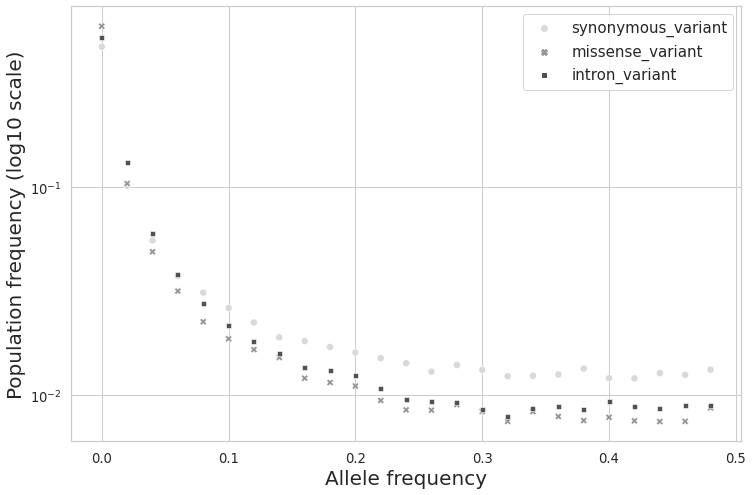

In [94]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.set_theme(style='whitegrid', font_scale=1.2)
sns.color_palette("pastel")

g = sns.scatterplot(
    data=fsfs_pd, x='af', y='ff', style='strata', hue='strata',
    ax=ax, s=50, palette='Greys'
)

_ = ax.set(yscale="log")

#_ = ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('1e%.1f'))
#_ = ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('1e%.1f'))
_ = ax.legend(prop={'size': 15})
_ = ax.set_xlabel('Allele frequency', fontsize=20)
_ = ax.set_ylabel('Population frequency (log10 scale)', fontsize=20)

In [98]:
fig = g.get_figure()
fig.savefig(BASE_DIR + '/data/figures/fsfs_effect.png', format='png', dpi=400)